In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2 


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import models as models
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm 
import gc


In [45]:
label_data = pd.read_csv("E:\\nose detection\\facial_keypoints.csv\\facial_keypoints.csv")
label_data = label_data.dropna()
label_index=label_data.index
full_label = label_data.values

image_data = np.load("E:\\nose detection\\face_images new\\face_images.npz")
# print(image_data.files)
image_data = image_data['face_images']
image_data = np.transpose(image_data,(2,0,1))
full_image = np.expand_dims(image_data[label_index],1)

In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(full_image,full_label,test_size=0.1)

## Face Dataset

In [47]:
class facedataset(torch.utils.data.Dataset):
    def __init__(self,image,label):
        self.image = image
        self.label = label
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self,idx):
        image = self.image[idx]/255
        label = self.label[idx]/96
        
        image = torch.as_tensor(image,dtype=torch.float32)
        label = torch.as_tensor(label,dtype=torch.float32)
        
        return image,label\

train_image = facedataset(X_train,y_train)
test_image = facedataset(X_test,y_test)

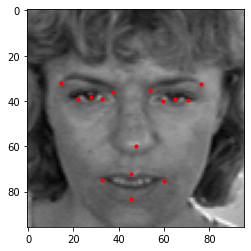

<Figure size 432x288 with 0 Axes>

In [48]:
def imageshow(data,idx):
    
    x = data[idx][1].reshape(15,2)[0:,0]*96
    y = data[idx][1].reshape(15,2)[0:,1]*96
    
    img = data[idx][0]
    img = np.transpose(img,(1,2,0))

    plt.imshow(img,cmap='gray')
    
    plt.scatter(x,y,c = "red", s = 10)
    plt.figure()
    
for  i in range(1):
    imageshow(test_image,i)  
    

## DataLoader

In [49]:
train_dl = torch.utils.data.DataLoader(train_image,shuffle=True,batch_size=16)
test_dl = torch.utils.data.DataLoader(test_image,shuffle=False,batch_size=16)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Resnet


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=30):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [11]:
test_image[3][0].shape
model = ResNet(ResidualBlock,layers=[3, 4, 6, 3])
model = model.to(device)
from torchsummary import summary
summary(model,(1,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             576
       BatchNorm2d-2           [-1, 64, 96, 96]             128
            Conv2d-3           [-1, 64, 96, 96]          36,864
       BatchNorm2d-4           [-1, 64, 96, 96]             128
            Conv2d-5           [-1, 64, 96, 96]          36,864
       BatchNorm2d-6           [-1, 64, 96, 96]             128
     ResidualBlock-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]          36,864
       BatchNorm2d-9           [-1, 64, 96, 96]             128
           Conv2d-10           [-1, 64, 96, 96]          36,864
      BatchNorm2d-11           [-1, 64, 96, 96]             128
    ResidualBlock-12           [-1, 64, 96, 96]               0
           Conv2d-13           [-1, 64, 96, 96]          36,864
      BatchNorm2d-14           [-1, 64,

## Traning 

In [64]:
#model = FaceLandMark().to(device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.01)
loss_fn = nn.L1Loss()
epoch = 7
train_loss = []

counter=0

for e in range(epoch):
    
    model.train()
    for i ,(img,lab) in enumerate(train_dl):
        
        img = img.to(device)
        lab = lab.to(device)
        
        outputs = model(img)
        loss = loss_fn(outputs,lab)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        train_loss.append(loss.cpu().detach().numpy())
    print(f"Epcoh[{e+1}/{epoch}] loss:{loss}")


Epcoh[1/7] loss:0.022636517882347107


## Evaluating

In [20]:
model.eval()

counter = 0

with torch.no_grad():
    for i ,(img,lab) in enumerate(train_dl):
        img,lab = img.to(device),lab.to(device)
        lab = lab.view(lab.size(0),-1)
        outputs = model(img)
        loss = loss_fn(outputs,lab)
        
    print(f"loss:(){loss}")

loss:()0.0012551393592730165


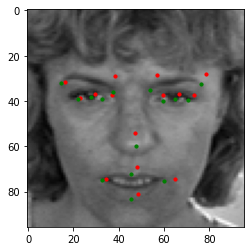

In [50]:
model = model.to('cpu')
with torch.no_grad():
    model.eval()
    for i,(img,lab) in enumerate(test_dl):
        pre = model(img)
        pre = pre[i].reshape(15,2)
        lab = lab[i].reshape(15,2)
        img= img[i]
        img = np.transpose(img,(1,2,0))
     
        plt.imshow(img,cmap='gray')
        for i in range(len(pre)):
            plt.scatter(pre[i][0]*96,pre[i][1]*96,c='red',s=10)
            plt.scatter(lab[i][0]*96,lab[i][1]*96,c='green',s=10)
        break